# Projekt zaliczeniowy - Przetwarzanie obrazów cyfrowych
Autor: **Patryk Ciepiela**

In [1]:
# Ładowanie bibliotek

import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, exposure, morphology, io, img_as_ubyte
from skimage.color import rgb2gray
from scipy.spatial import distance
import cv2
import warnings
import time
import math
import colorsys

In [2]:
COLOR_FOREGROUND = 255
COLOR_BACKGROUND = 0
COLOR_FOREGROUND_INV = 0
COLOR_BACKGROUND_INV = 255

DEBUG = False
if not DEBUG:
    warnings.filterwarnings('ignore')

In [3]:
# Metody pomocnicze
def is_in_image(shape, px=0, py=0):
    return ((px>=0) and (px < shape[0]) and (py >= 0) and (py < shape[1]))

def bfs(i,j,image,color):
    q = [(i,j)]
    while q:
        ii,jj = q.pop(0)
        for dx in range(-1,2):
            for dy in range(-1,2):
                if dx == 0 and dy == 0:
                    continue
                a = ii + dx
                b = jj + dy
                if is_in_image(image.shape, a, b) and image[a][b] == COLOR_FOREGROUND_INV:
                    image[a][b] = color
                    q.append((a,b))

def segment(image):
    segment_table = image.copy()
    cnt = 1
    x = 0
    for i in range(segment_table.shape[0]):
        for j in range(segment_table.shape[1]):
            v = segment_table[i][j]
            if v == COLOR_FOREGROUND_INV:
                x += 1
                segment_table[i][j] = cnt
                bfs(i,j,segment_table,cnt)
                cnt += 1
                
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            v = segment_table[i][j]
            if v == COLOR_BACKGROUND_INV:
                segment_table[i][j] = 0
                
    return x,segment_table

# metoda wyświetlająca obraz w notatniku
def showimg(img, title="Obraz", verbose=False, cmap="gray"):
    if verbose:
        print(img.shape, img.dtype)
    plt.figure(figsize=(15,10))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.suptitle(title)
    plt.show()

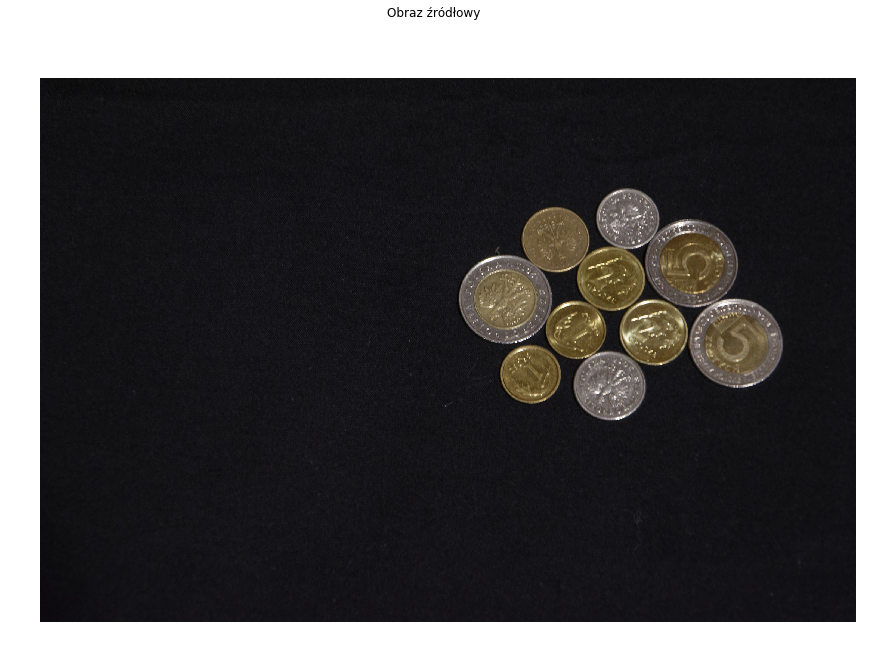

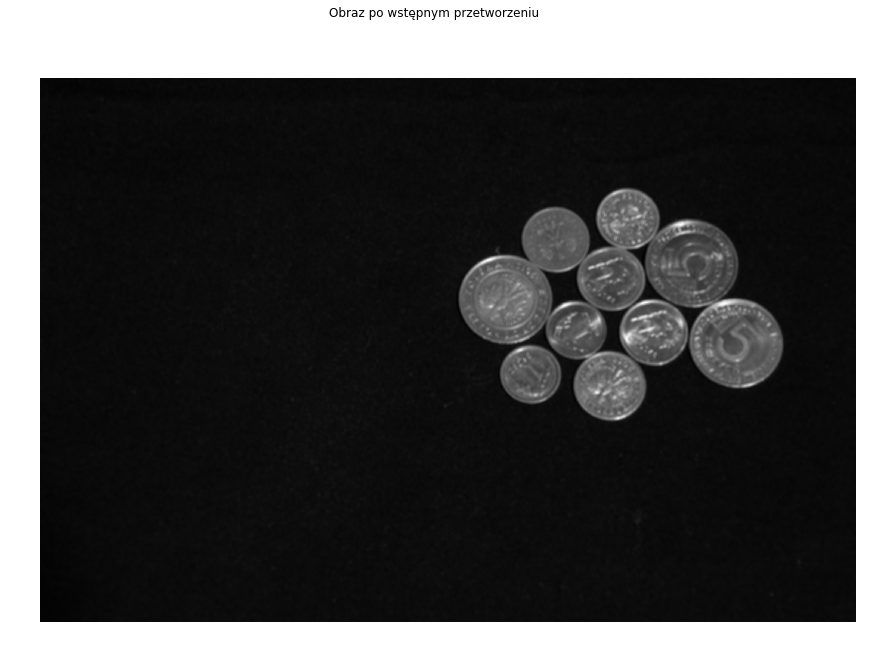

In [4]:
sourceimg = io.imread("source.jpg")

showimg(sourceimg, title="Obraz źródłowy")

processedimg = sourceimg.copy()
processedimg = img_as_ubyte(rgb2gray(processedimg))
processedimg = cv2.blur(processedimg, (11,11))

bwblurredimg = processedimg.copy()

showimg(bwblurredimg, title="Obraz po wstępnym przetworzeniu")

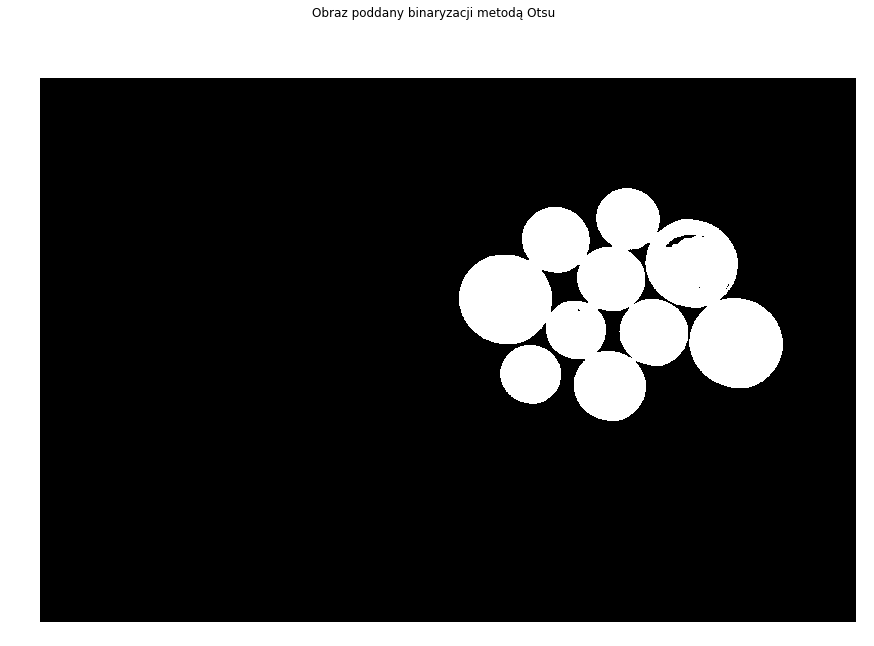

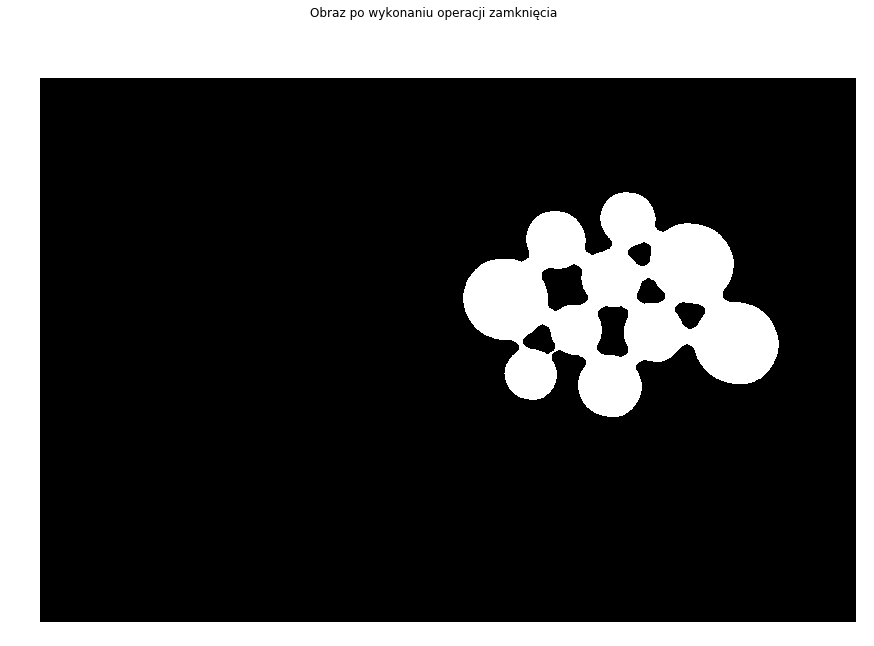

In [5]:
th = 128
th, bim = cv2.threshold(bwblurredimg, thresh=th, maxval=255, type=cv2.THRESH_OTSU)
processedimg = bim
showimg(processedimg, title="Obraz poddany binaryzacji metodą Otsu")

morphKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
processedimg = cv2.bitwise_not(processedimg)
processedimg = cv2.morphologyEx(processedimg, op=cv2.MORPH_OPEN, kernel=morphKernel, iterations=4)
processedimg = cv2.morphologyEx(processedimg, op=cv2.MORPH_DILATE, kernel=morphKernel, iterations=5)
processedimg = cv2.bitwise_not(processedimg)

binaryimg = processedimg.copy()

showimg(processedimg, title="Obraz po wykonaniu operacji zamknięcia")


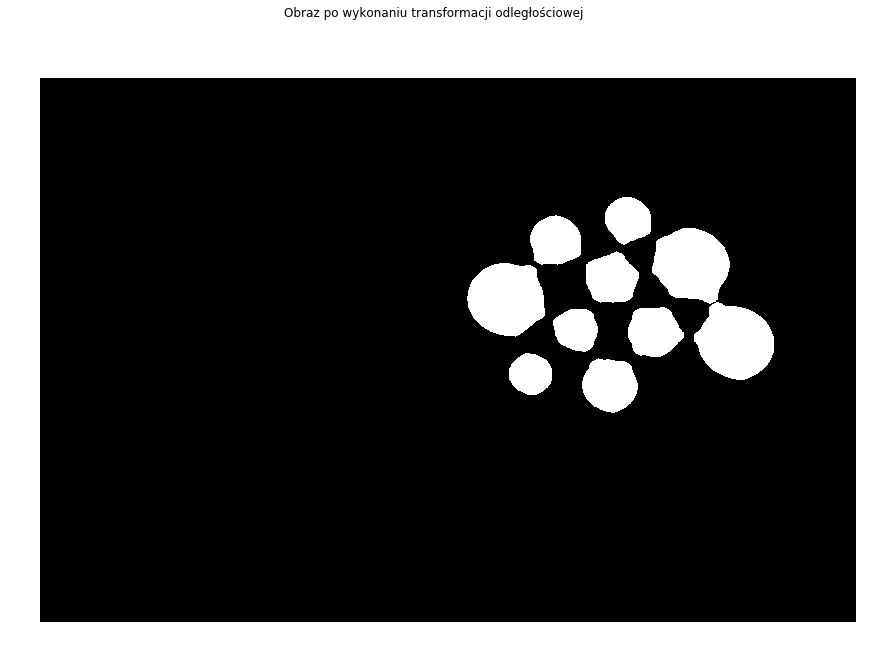

In [6]:
distimg = cv2.distanceTransform(binaryimg, cv2.DIST_L2, 5)
distimg = np.uint8(distimg)
_, distimg = cv2.threshold(distimg, thresh=46, maxval=255, type=cv2.THRESH_BINARY)
distimg = cv2.morphologyEx(distimg, op=cv2.MORPH_DILATE, kernel=morphKernel, iterations=10)
showimg(distimg, title="Obraz po wykonaniu transformacji odległościowej")

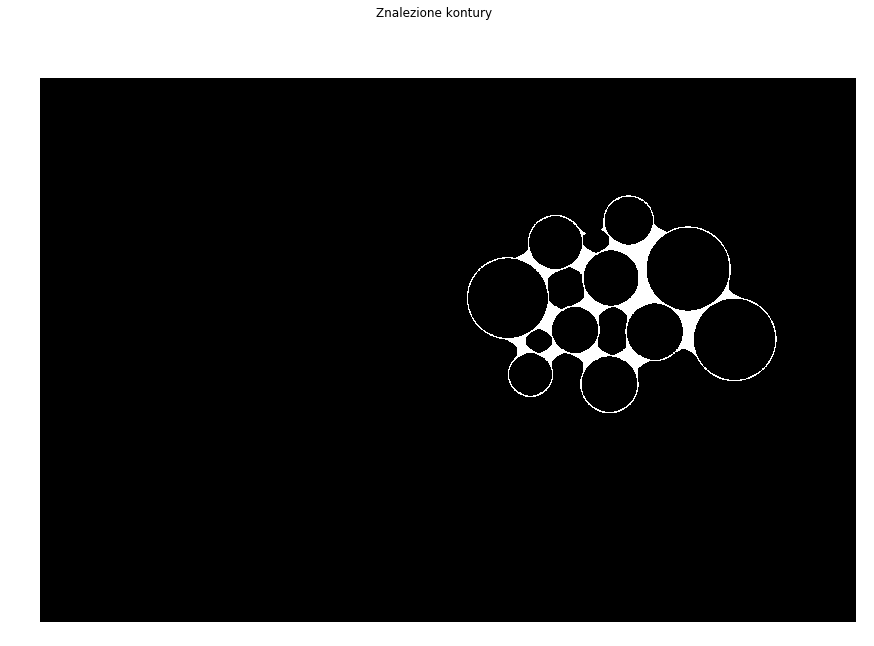

In [7]:
_, contours, hierarchy = cv2.findContours(distimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contoursimg = np.zeros_like(binaryimg)
for i in range(len(contours)):
    mycircle = contours[i]
    (x,y),radius = cv2.minEnclosingCircle(mycircle)
    center = (int(x),int(y))
    radius = int(radius)
    cv2.circle(contoursimg,center,radius,255,3)
contoursimg = cv2.morphologyEx(contoursimg, op=cv2.MORPH_CLOSE, kernel=morphKernel, iterations=15)
showimg(contoursimg, title="Znalezione kontury")

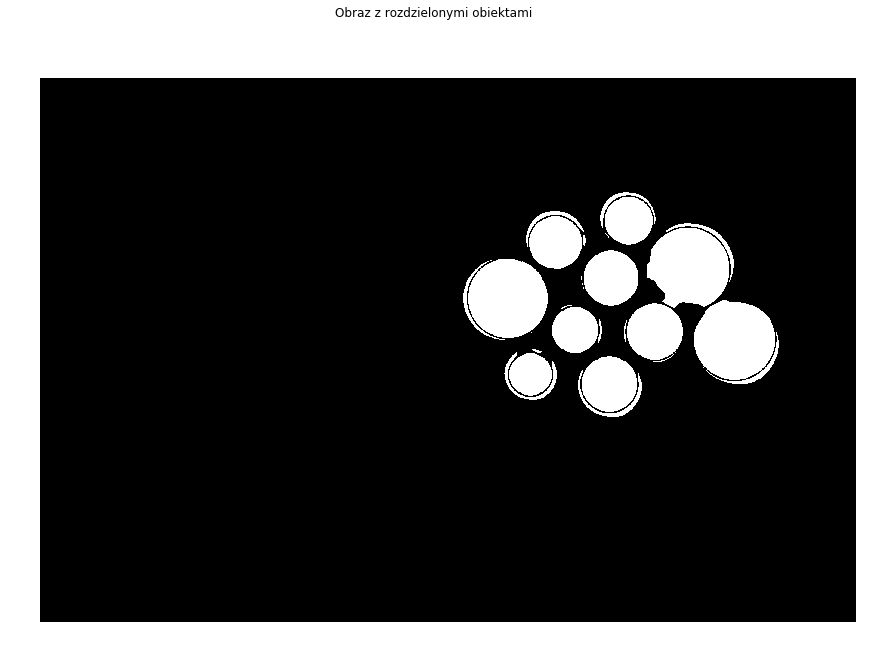

In [8]:
separated_img = cv2.bitwise_and(processedimg, cv2.bitwise_not(contoursimg))
showimg(separated_img, title="Obraz z rozdzielonymi obiektami")

In [9]:
time_now = time.time()
_, segment_table = segment(cv2.bitwise_not(separated_img))
time_delta = time.time() - time_now
print("Segmentacja ukończona w %.3f sekund" % time_delta)

Segmentacja ukończona w 19.606 sekund


Liczba obiektów: 10
{2: 24358, 4: 29536, 6: 68071, 9: 32121, 10: 66972, 14: 68211, 15: 33465, 17: 22623, 28: 19025, 31: 32735}


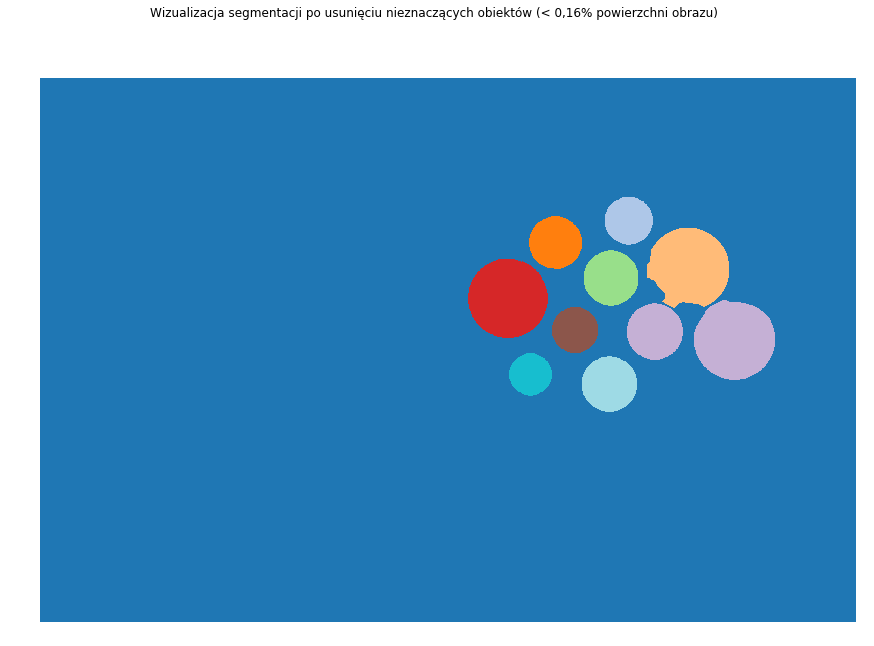

In [10]:
denoised_segment = morphology.remove_small_objects(segment_table, min_size=10000)
unique_elements, counts_elements = np.unique(denoised_segment, return_counts=True)
obj_area = dict(zip(unique_elements[1:], counts_elements[1:]))
print("Liczba obiektów: %d" % len(obj_area))
print(obj_area) 
showimg(denoised_segment, cmap="tab20", title="Wizualizacja segmentacji po usunięciu nieznaczących obiektów (< 0,16% powierzchni obrazu)")

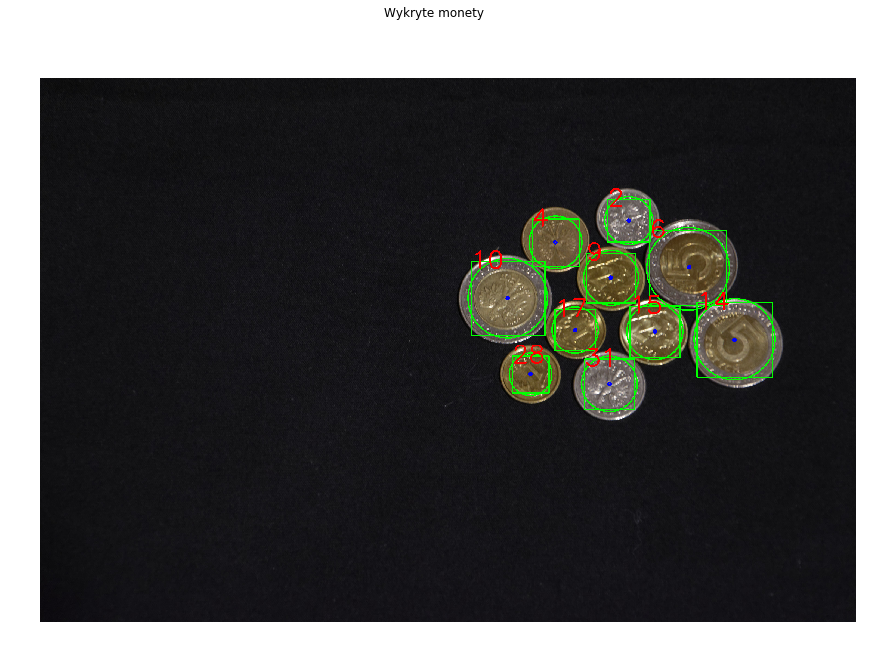

In [11]:
detected_coins = sourceimg.copy()
bbox_margin = 10;
obj_data = []
for key in obj_area.keys():
    _, contours, hier = cv2.findContours(np.uint8(denoised_segment==key), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        (x2,y2),radius = cv2.minEnclosingCircle(c)
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        obj_data.append({'id':key, 'x': x, 'y': y, 'width': w, 'height': h, 'centroid': (cX, cY), 'contours':c, 'area': obj_area[key]})
        cv2.circle(detected_coins, (cX,cY), 5, (0,0,255), 5)
        cv2.circle(detected_coins, (int(x2),int(y2)), int(radius), (0,255,0), 3)
        cv2.rectangle(detected_coins, (x+bbox_margin, y+bbox_margin), (x+w-bbox_margin, y+h-bbox_margin), (0, 255, 0), 3)
        cv2.putText(detected_coins, str(key), (x+bbox_margin, y+bbox_margin+25), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,0,0), 5)
showimg(detected_coins, title="Wykryte monety")

In [12]:
def getFigure(labelledImage, obj_id):
    points = []
    for y in range(labelledImage.shape[0]):
        for x in range(labelledImage.shape[1]):
            if labelledImage[y,x] == obj_id:
                points.append((y,x))
    return points

def BlairBlissCoeff(points, obj_centroid):
    s = len(points)
    mx, my = obj_centroid
    r = 0
    for point in points:
         r = r + distance.euclidean(point,(my,mx))**2
    return s/(math.sqrt(2*math.pi*r))

def FeretCoeff(points):
    px = [x for (y,x) in points]
    py = [y for (y,x) in points]
    
    fx = max(px) - min(px)
    fy = max(py) - min(py)
    
    return float(fy)/float(fx)

def HaralickCoeff(centroid, contours):
    n = len(contours)
    mx, my = centroid
    d1 = 0
    d2 = 0
    for i in range(n):
        d1 += distance.euclidean((contours[i][0][1], contours[i][0][0]),(my,mx))
        d2 += (distance.euclidean((contours[i][0][1], contours[i][0][0]),(my,mx))**2 - 1)
    return math.sqrt((d1**2)/(n*d2))

def AverageColor(image):
    avg = image.mean(axis=0).mean(axis=0)
    h,s,v = colorsys.rgb_to_hsv(avg[0]/255, avg[1]/255, avg[2]/255)
    return (h*360, s*100, v*100)

def is_within(value, desired, margin=0):
    is_above_min = value >= (desired - margin)
    is_below_max = value < (desired+margin)
    return is_above_min and is_below_max

def TryToGuessValue(area, color):
    penny_h = 38
    dime_h = 27
    h_margin = 6
    h,s,v = color
    if(area < 20000 and is_within(h,penny_h,h_margin)): # 1gr
        return 0.01
    elif(is_within(area, 25000, 1000) and is_within(h,penny_h,h_margin)): # 2gr
        return 0.02
    elif(is_within(area, 34000, 4000) and is_within(h,penny_h,h_margin)): # 5gr
        return 0.05
    elif(is_within(area, 23000, 1500) and is_within(h, dime_h, h_margin)): # 10gr
        return 0.1
    elif(is_within(area, 29000, 2000) and is_within(h, dime_h, h_margin)): # 20gr
        return 0.2
    elif(is_within(area, 36000, 3000) and is_within(h, dime_h, h_margin)): # 50gr
        return 0.5
    elif(area > 45000 and is_within(h, dime_h, h_margin)): # 1zl
        return 1
    elif(is_within(area, 45000, 2500) and is_within(h, penny_h, h_margin)): # 2zl
        return 2
    elif(area > 50000 and is_within(h, penny_h, h_margin)): # 5zl
        return 5
    else:
        return 0

In [13]:
print("Obliczanie współczynników dla obiektów")
for obj in obj_data:
    points = getFigure(denoised_segment, obj["id"])
    centroid = obj["centroid"]
    feretCoeff = FeretCoeff(points)
    bbCoeff = BlairBlissCoeff(points, centroid)
    haraCoeff = HaralickCoeff(centroid, obj["contours"])
    print("ID: %d\t| Centroid: (%d,%d)\t| Feret: %.9f\t| Blair-Bliss: %.9f\t| Haralick: %.9f" 
          % (obj["id"], centroid[0], centroid[1], feretCoeff, bbCoeff, haraCoeff))

Obliczanie współczynników dla obiektów
ID: 2	| Centroid: (2164,524)	| Feret: 1.011494253	| Blair-Bliss: 0.999921176	| Haralick: 1.000040995
ID: 4	| Centroid: (1894,604)	| Feret: 1.005208333	| Blair-Bliss: 0.999776407	| Haralick: 0.999993078
ID: 6	| Centroid: (2386,695)	| Feret: 0.980132450	| Blair-Bliss: 0.995170282	| Haralick: 0.998809960
ID: 9	| Centroid: (2098,734)	| Feret: 1.010000000	| Blair-Bliss: 0.999764232	| Haralick: 0.999986543
ID: 10	| Centroid: (1719,809)	| Feret: 1.003448276	| Blair-Bliss: 0.999934140	| Haralick: 1.000004900
ID: 14	| Centroid: (2552,963)	| Feret: 0.993243243	| Blair-Bliss: 0.999215358	| Haralick: 0.999814362
ID: 15	| Centroid: (2260,932)	| Feret: 1.009803922	| Blair-Bliss: 0.999969558	| Haralick: 1.000036387
ID: 17	| Centroid: (1967,926)	| Feret: 1.011904762	| Blair-Bliss: 0.999891261	| Haralick: 1.000038332
ID: 28	| Centroid: (1803,1088)	| Feret: 1.012987013	| Blair-Bliss: 0.999665153	| Haralick: 0.999993774
ID: 31	| Centroid: (2093,1124)	| Feret: 1.0099

In [14]:
moneysum = 0
for myObj in obj_data:
    objColorImg = sourceimg[myObj['y']:myObj['y']+myObj['height'],myObj['x']:myObj['x']+myObj['width'],:]
    objColorImg = cv2.blur(objColorImg, (9,9))
    imgColor = AverageColor(objColorImg)
    moneysum += TryToGuessValue(myObj["area"], imgColor)
print("Łącznie na obrazku \"jest\" około " + str(round(moneysum, 2)) + " zł")

Łącznie na obrazku "jest" około 15.11 zł
